# Trying out Minigrad

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import random
from minigrad.engine import Value
from minigrad.nn import MLP


In [3]:
np.random.seed(1337)
random.seed(1337)


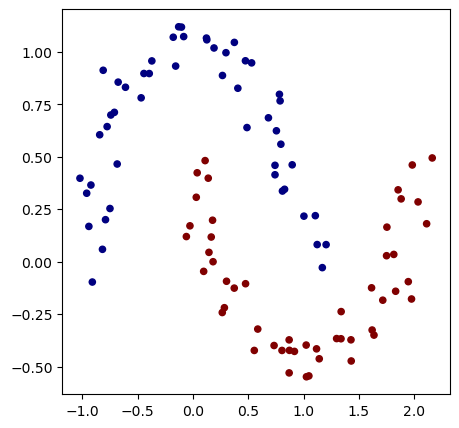

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network with 16 neurons each
print(model)
print("number of parameters", len(model.parameters()))

MLP with 3 layers and 337 parameters
number of parameters 337


In [6]:
def loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(Value(1) + -Value(yi) * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses, Value(0)) * (Value(1.0) / Value(len(losses)))  # Use Value objects
    
    # L2 regularization
    alpha = Value(1e-4)  # Use Value object
    reg_loss = alpha * sum((p * p for p in model.parameters()), Value(0))  # Use Value objects
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.1815924818239036, grad=0.0, name = None) 0.5


In [7]:
model.set_optimizer('sgd', lr=0.1)  # Set SGD optimizer with learning rate 0.01

# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
   
    # update weights using the optimizer
    model.step()
  
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.1815924818239036, accuracy 50.0%
step 1 loss 0.6867816844967566, accuracy 73.0%
step 2 loss 0.6591813010058771, accuracy 82.0%
step 3 loss 0.6442576802446304, accuracy 74.0%
step 4 loss 0.6374418625061422, accuracy 85.0%
step 5 loss 0.6235685643237718, accuracy 79.0%
step 6 loss 0.6151774273382826, accuracy 86.0%
step 7 loss 0.6118741505694453, accuracy 78.0%
step 8 loss 0.6053196316311713, accuracy 87.0%
step 9 loss 0.5990139944915752, accuracy 80.0%
step 10 loss 0.5931807804694633, accuracy 87.0%
step 11 loss 0.5884190044137632, accuracy 86.0%
step 12 loss 0.5847454989930503, accuracy 86.0%
step 13 loss 0.5810243612345648, accuracy 86.0%
step 14 loss 0.577432715044194, accuracy 87.0%
step 15 loss 0.5743260947746517, accuracy 87.0%
step 16 loss 0.5712063426273126, accuracy 87.0%
step 17 loss 0.568208698316158, accuracy 88.0%
step 18 loss 0.5655144303253388, accuracy 88.0%
step 19 loss 0.5629223627490185, accuracy 88.0%
step 20 loss 0.560345072084427, accuracy 88.0%
step 

(-1.548639298268643, 1.951360701731357)

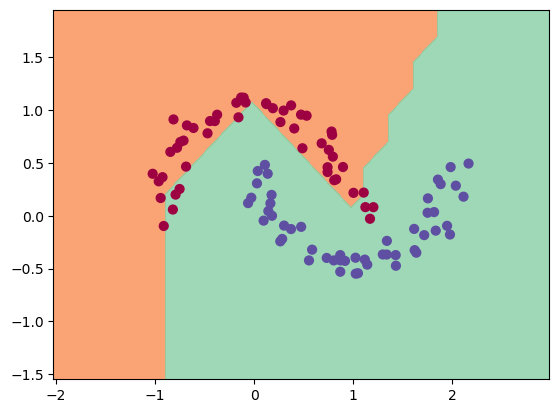

In [8]:
 # visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())